In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset

In [26]:
df=pd.read_csv('Bengaluru_House_Data.csv')

In [27]:
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


# EDA (Exploratory Data Analysis)

In [28]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [29]:
df.shape

(13320, 9)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [31]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64


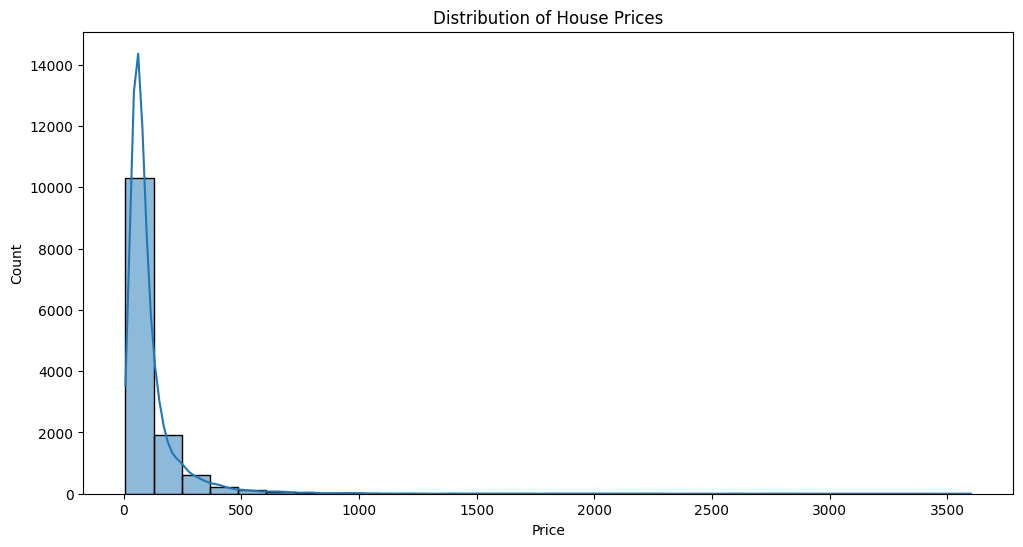

In [32]:
# Visualize the distribution of the target variable (price)
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.show()

In [33]:
# Data Cleaning
# Data Cleaning
df['balcony'].fillna(df['balcony'].mode()[0], inplace=True)
df['bath'].fillna(df['bath'].mode()[0], inplace=True)
df['size'].fillna(df['size'].mode()[0], inplace=True)
df['location'].fillna(df['location'].mode()[0], inplace=True)

In [34]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [37]:
# Assuming 'total_sqft' contains values like '1000 - 1500' and you want to take the average
def convert_sqft_to_num(sqft):
    try:
        tokens = sqft.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(sqft)
    except:
        return None

In [38]:
# Feature Engineering
df['BHK'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

In [40]:
def remove_bhk_outlier(df):
    bhk_stats = df.groupby('BHK')['total_sqft'].agg(['mean', 'std']).reset_index()
    outliers = pd.DataFrame()

    for bhk, stats in bhk_stats.iterrows():
        lower_bound = stats['mean'] - (3 * stats['std'])
        upper_bound = stats['mean'] + (3 * stats['std'])
        bhk_outliers = df[(df['BHK'] == bhk) & ((df['total_sqft'] < lower_bound) | (df['total_sqft'] > upper_bound))]
        outliers = pd.concat([outliers, bhk_outliers], ignore_index=True)

    df_no_outliers = df[~df.isin(outliers)].dropna()
    return df_no_outliers

In [41]:
# Outlier Removal
df = remove_bhk_outlier(df)

In [42]:
# Categorize locations
location_stats = df['location'].value_counts()
location_stats_less_than_10 = location_stats[location_stats <= 10]
df['location'] = df['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

In [44]:
# Encode categorical features
from sklearn.preprocessing import LabelEncoder


df['area_type'] = LabelEncoder().fit_transform(df['area_type'])
df['society'] = LabelEncoder().fit_transform(df['society'])
df['availability'] = LabelEncoder().fit_transform(df['availability'])



In [45]:
# Model Building
x = df.drop(['price'], axis='columns')
y = df['price']

In [56]:
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,BHK
0,3,37,Electronic City Phase II,2 BHK,460,1056.0,2.0,1.0,39.07,2.0
1,2,76,Chikka Tirupathi,4 Bedroom,2431,2600.0,5.0,3.0,120.00,4.0
6,3,31,Old Airport Road,4 BHK,933,2732.0,4.0,2.0,204.00,4.0
24,3,32,other,1 RK,295,510.0,1.0,0.0,25.25,1.0
29,3,76,Electronic City,3 BHK,983,1025.0,2.0,1.0,47.00,3.0
...,...,...,...,...,...,...,...,...,...,...
13313,3,76,Uttarahalli,3 BHK,107,1345.0,2.0,1.0,57.00,3.0
13314,3,76,Green Glen Layout,3 BHK,2218,1715.0,3.0,3.0,112.00,3.0
13315,0,76,Whitefield,5 Bedroom,208,3453.0,4.0,0.0,231.00,5.0
13317,0,76,Raja Rajeshwari Nagar,2 BHK,1209,1141.0,2.0,1.0,60.00,2.0


In [47]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Assuming x is your DataFrame
numeric_cols = x.select_dtypes(include=['number']).columns
x_numeric = x[numeric_cols]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_numeric)


In [57]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,BHK
0,3,37,Electronic City Phase II,2 BHK,460,1056.0,2.0,1.0,39.07,2.0
1,2,76,Chikka Tirupathi,4 Bedroom,2431,2600.0,5.0,3.0,120.00,4.0
6,3,31,Old Airport Road,4 BHK,933,2732.0,4.0,2.0,204.00,4.0
24,3,32,other,1 RK,295,510.0,1.0,0.0,25.25,1.0
29,3,76,Electronic City,3 BHK,983,1025.0,2.0,1.0,47.00,3.0


In [48]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=10)



In [49]:
# SVM Regression with Grid Search for Hyperparameter Tuning
param_grid = {'C': [1, 10, 100], 'epsilon': [0.1, 0.2, 0.5], 'kernel': ['linear', 'rbf']}
svm_model = SVR()
grid_search = GridSearchCV(svm_model, param_grid, scoring='r2', cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1, 10, 100], 'epsilon': [0.1, 0.2, 0.5],
                         'kernel': ['linear', 'rbf']},
             scoring='r2')

In [55]:
# Get the best model
best_svm_model = grid_search.best_estimator_
test_score = best_svm_model.score(x_test, y_test)

test_score

0.725236378827832

In [59]:
# Price Prediction Function
def predict_price(location, sqft, bath, BHK, area_type, society, balcony, availability, x, scaler):
    loc_index = np.where(x.columns == location)[0][0] if location in x.columns else -1
    features = np.zeros(len(x.columns)-2)
    features[0] = sqft
    features[1] = bath
    features[2] = BHK
    features[3] = area_type
    features[4] = society
    features[5] = balcony
    features[6] = availability
    if loc_index >= 0:
        features[loc_index] = 1
    features_scaled = scaler.transform([features])
    return best_svm_model.predict(features_scaled)[0]


In [60]:
# Example usage:
predicted_price = predict_price('Indira Nagar', 1000, 3, 3, 0, 1, 2, 1, x, scaler)
print("Predicted Price:", predicted_price)

# Print results
print("Best SVM Model:", best_svm_model)
print("Test Score of the Best SVM Model:", test_score)

Predicted Price: 221.7907974246969
Best SVM Model: SVR(C=100, epsilon=0.5)
Test Score of the Best SVM Model: 0.725236378827832
